In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmasher as cmr
import tensorweave as tw

# Set device
device = "cpu"
dtype = torch.float32

In [2]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../additional_utils/Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

In [3]:
# Read the Canobie Dataset (and also subsample along the flight lines)
canobie_dataset = tw.read_and_subsample_lines("../Datasets/canobie_full.csv",
                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], # [l_id, x, y, z, xx, xy, xz, yy, yz, zz]
                                              radius=100, delimiter=",")

In [4]:
# Extract the relevant data
line_id = canobie_dataset[:, 0]
xyz = canobie_dataset[:, 1:4]
ftg = canobie_dataset[:, 4:]

# Remove the mean
mean_xy = np.mean(xyz, axis=0)
# Remove the z mean
mean_xy[-1] = 0.
# De-mean the data
xyz = xyz - mean_xy[None, :]

In [5]:
# Generate a grid and masks!
import alphashape
import shapely
from sklearn.neighbors import KDTree as kdt

# Create a concave polygon for masking the region of interest
multipoint = xyz[:, :-1]
alpha_value = 1.9e-3
concave_polygon = alphashape.alphashape(multipoint, alpha_value)

# Create a grid
inc = 5e2
padding = 1e3
x_mesh = np.arange(xyz[:, 0].min() + padding, xyz[:, 0].max() - padding, inc)
y_mesh = np.arange(xyz[:, 1].min() + padding, xyz[:, 1].max() - padding, inc)
xx, yy = np.meshgrid(x_mesh, y_mesh)
xvec, yvec = xx.ravel(), yy.ravel()
zvec = 25 * np.ones_like(xvec)
grid = np.c_[xvec, yvec, zvec]

# Create a mask
# First do a KDTree approach to remove most points
known_tree = kdt(xyz[:, :-1])
init_map_distance, _ = known_tree.query(grid[:, :-1], k=1, return_distance=True)
init_map = (init_map_distance < 7e2 * inc).ravel()

# Now only check the points that are within the concave polygon
close_grid_points = shapely.points(grid[init_map, :-1])
final_actv = concave_polygon.contains(close_grid_points)

# The final mask
actv = np.zeros_like(init_map)
actv[init_map] = final_actv

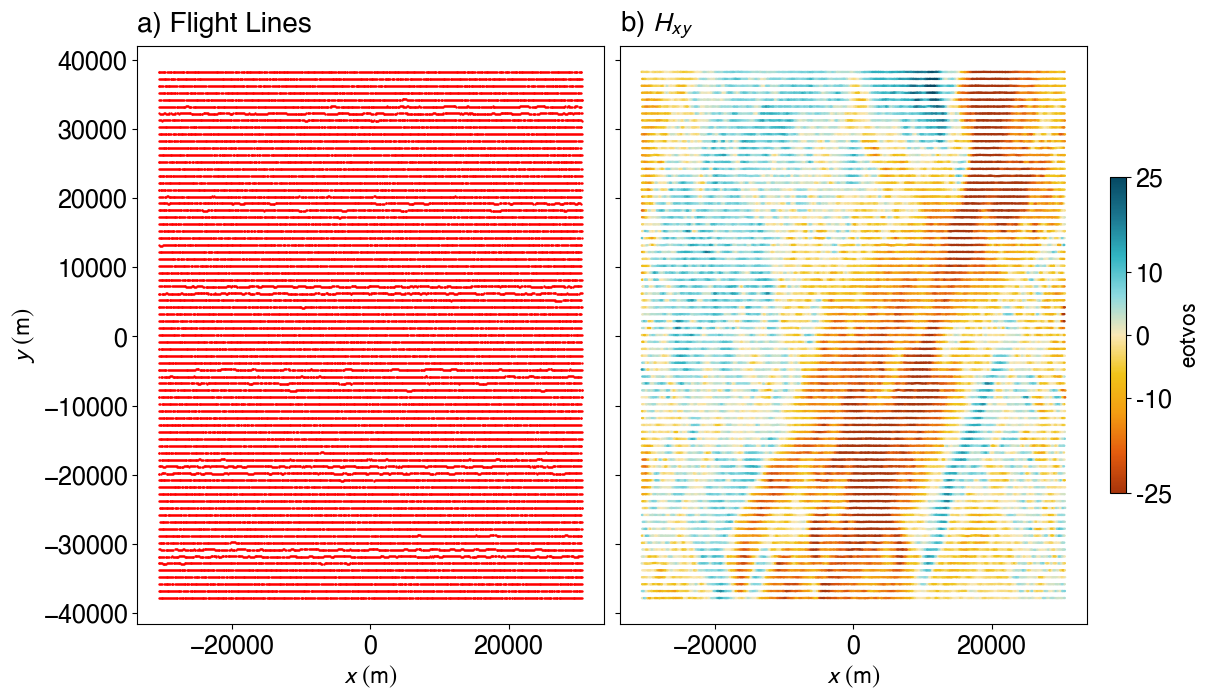

In [6]:
# Plot the flight lines
fig, ax_ = plt.subplots(1, 2, figsize=(12, 8), layout="constrained", sharex=True, sharey=True)
ax_ = ax_.ravel()

for i in range(2):
    if i == 0:
        ax = ax_[i]
        m1 = ax.scatter(xyz[:, 0], xyz[:, 1], s=0.5, c="r")
        ax.set_aspect("equal")
        ax.set_title(r"a) Flight Lines", loc="left", pad=10)
        ax.set_ylabel(r"$y\ (\mathrm{m})$")
        ax.set_xlabel(r"$x\ (\mathrm{m})$")

    elif i == 1:
        ax = ax_[i]
        m = ax.scatter(xyz[:, 0], xyz[:, 1], s=0.5, c=ftg[:, 2],
                   cmap=curlew_cont, vmin=-25, vmax=25)
        ax.set_aspect("equal")
        plt.colorbar(mappable=m, ax=ax, ticks=[-25, -10, 0, 10, 25],
                     format="%.0f", shrink=0.4, label=r"$\mathrm{eotvos}$")
        ax.set_title(r"b) $H_{xy}$", loc="left", pad=10)
        ax.set_aspect("equal")
        ax.set_xlabel(r"$x\ (\mathrm{m})$")

plt.savefig("./Figures/canobie_data.png")
plt.show()

In [7]:
# Prepare the data for training. We create a perturbation in the z direction to help the model converge faster.
xyz_perturb = np.copy(xyz)
xyz_perturb[:, 2] += (np.random.randn(xyz.shape[0]))
# Convert to torch Tensors
xyz_torch = torch.tensor(xyz_perturb, device=device, dtype=dtype)
ftg_torch = torch.tensor(ftg, device=device, dtype=dtype)  # xx, xy, xz, yy, yz, zz

# Preload active grid points (for Laplacian loss)
actv_points = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)
actv_points_torch = torch.tensor(actv_points, device=device, dtype=dtype)

In [ ]:
# Initialise
model = tw.NeuralFourierField(num_fourier_features=64, length_scales=[1e3, 1e4, 1e5], learnable=True, potential_scale=2e7,
                           device=device, hidden_layers=[1024, 512, 256], activation=nn.SiLU(), seed=42)

# Fit!
losses, lapl_counts = model.fit(xyz_torch, ftg_torch, actv_points_torch, epochs=400, lr=1e-2, lap_spacing=(1e4, 1e3, 6, 1, 30),
                                lap_samples=1000, chunk_size=1024, batch_size=8192)

Training:   4%|▍         | 17/400 [05:10<1:56:39, 18.28s/it, loss=43.2419, ftg=[8.440, 3.859, 8.935, 5.041, 6.188, 10.699], lap=0.052, lr=0.01, lap_ns=36, stall=0]      


KeyboardInterrupt: 

In [9]:
# Evaluate using the predict method N.B: predict() outputs a numpy array, for a numpy array input.
predicted_hessian = model.predict(actv_points, output="hessian", chunk_size=2048)
# Create an array to hold gradient components over the full grid
hess_components = np.full((xvec.shape[0], 6), np.nan)
# Reshape the predicted hessian and store it in the hess_components array
hess_components[actv] = predicted_hessian.reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)] # xx, xy, xz, yy, yz, zz

In [10]:
# Plotting indices and parameters
# Select indices corresponding to H_xx, H_xy, H_xz for display (adjust if needed)
idx = [0, 1, 2]
# Labels for NF, RBF and CT
nf_labels = [r"$H^{\mathrm{NF}}_{xx}$", r"$H^{\mathrm{NF}}_{xy}$", r"$H^{\mathrm{NF}}_{xz}$",
             r"$H^{\mathrm{NF}}_{yy}$", r"$H^{\mathrm{NF}}_{yz}$", r"$H^{\mathrm{NF}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
ct_labels = [r"$H^{\mathrm{CT}}_{xx}$", r"$H^{\mathrm{CT}}_{xy}$", r"$H^{\mathrm{CT}}_{xz}$",
             r"$H^{\mathrm{CT}}_{yy}$", r"$H^{\mathrm{CT}}_{yz}$", r"$H^{\mathrm{CT}}_{zz}$"]
# Colormap capping
cmax = 15

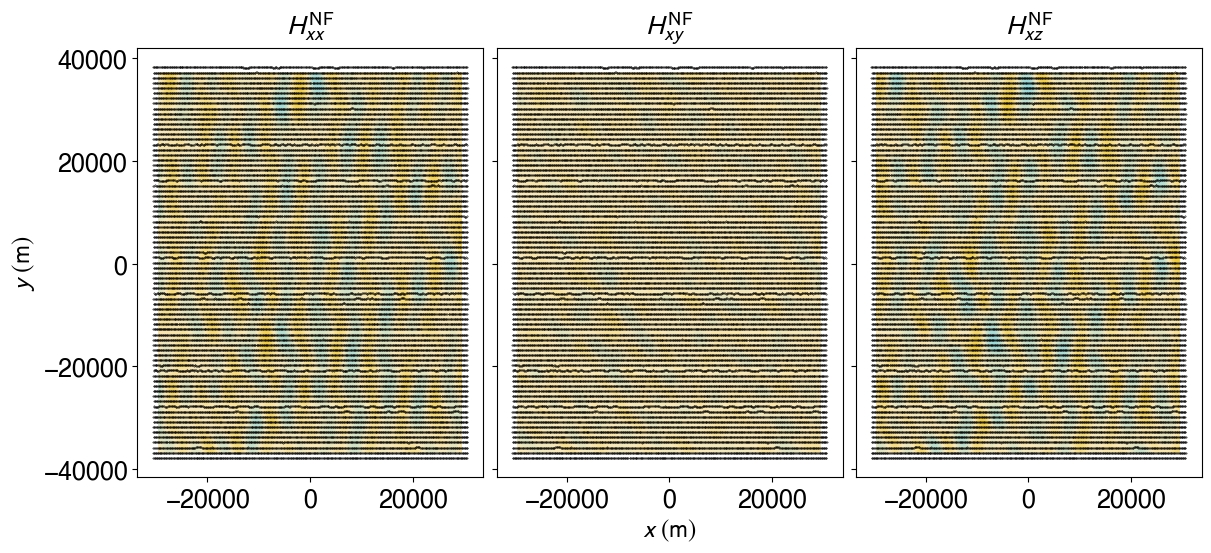

In [11]:
# Plot the NF!
fig, ax = plt.subplots(1, 3, figsize=(12, 6), layout="compressed", sharex=True, sharey=True)

# Contour plots
for i in range(3):
    ax[i].contourf(
        x_mesh, y_mesh, hess_components[:, idx[i]].reshape(xx.shape),
        levels=np.linspace(-cmax, cmax, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(nf_labels[idx[i]], pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[1].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k') for a_ in ax]

plt.show()